# Пункт 1. Реализовать стохастический градиентный спуск

In [20]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# # suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

In [21]:
DEFAULT_LR = 0.005

In [22]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, coefficient_bound = 0):
    return np.sum(coefficients * x) + coefficient_bound * (2 * np.random.random_sample() - 1)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

class point_set:
    # copy ctor :|
    def __init__(self, n, dim, x, y, coords_bound = 0):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, f(coefficients, x[i], coefficients_bound))
    # y = coords_bound * np.random.random_sample((n))
    return point_set(n, dim, x, y, coords_bound)

# EPOCH_MAX = 1000
# input_2d = create_point_set(30, 2, 10., 2.)
# input_3d = create_point_set(30, 3, 10., 2.)
# input_small = create_point_set(25, 5, 20., 1.)
# input_large = create_point_set(30, 10, 30., 2.)
# input_wild = create_point_set(5, 6, 1000., 1.)
# input_custom = create_point_set(30, 2, 20, 0, [-5, 3])

EPOCH_MAX = 50
input_2d = create_point_set(100, 2, 20., 10.)
input_3d = create_point_set(50, 3, 20., 10.)
# input_small = create_point_set(150, 100, 20., 1.)
input_large = create_point_set(10, 10, 20., 10.)
# input_wild = create_point_set(100, 20, 1000., 1.)
# input_custom = create_point_set(150, 20, 20, 0, [-5, 3])

In [23]:
# considered loss function for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
# def loss_function(points, c):
#     f = 0
#     for i in range(0, points.n):
#         f += (np.asarray(c[0 : points.dim - 1], dtype=np.float64) @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
#     return f
def loss_function(points, coeffs, i):
    return 1 / (2 * points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

In [24]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0
    return grad

# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [25]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   _param - ignored
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, _param_1, _param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)

        # print(coeffs_step)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [26]:
constant_lr = (lambda current_lr, epoch: DEFAULT_LR)
def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))
   
colors = ["blue", "red", "green", "orange", "purple", "yellow", "pink", "brown", "black", "magenta"]

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr, gd = sgd, param_1 = 0, param_2 = 0):
    epoches = np.asarray([])
    for batch in range(1, points.n + 1):
        result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
        epoches = np.append(epoches, len(result[1]))    
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr, gd = sgd, name='minibatch SGD', params_1 = [0], params_2 = [0]):
    if params_1 == [0] and params_2 == [0]:
        epoches = batch_size_analyze(points, lr, gd = gd, param_1 = 0)
        plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
    if params_1 != [0] and params_2 == [0]:
        for i in range(0, len(params_1)):
            epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i])
            plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[i % len(colors)], label = "parameter=" + str(params_1[i]))
        plt.legend()
    if params_1 != [0] and params_2 != [0]:
        for i in range(0, len(params_1)):
            for j in range (0, len(params_2)):
                epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i], param_2 = params_2[j])
                plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[(i*len(params_2)+j) % len(colors)], label = str(params_1[i])+ " " + str(params_2[j])) 
            plt.legend()
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [27]:
def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

# draw loss func values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_loss_function_epochs(points, batch, lr = constant_lr, gd = sgd, name = 'minibatch SGD', param = 0, p = 0):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param, p)

    loss_func_values = np.asarray([])
    for coeffs in result[1]:
        loss_func_values = np.append(loss_func_values, [apply_all_loss_functions(points, coeffs)])
        
    plt.plot(loss_func_values)
    plt.xlabel("epoch")
    plt.ylabel("loss function value")
    plt.title("loss function by " + name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [28]:

def print_2d_result(points, lr = constant_lr, gd = sgd, param_1 = 0, param_2 = 0):
    # print("here")
    result = gd(points, points.n // 2, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

##### Запуски SGD, minibatch SGD, GD на различных наборах точек:

In [29]:
# print_batch_size_analyze(input_2d)
# print_batch_size_analyze(input_3d)
# print_batch_size_analyze(input_small)
# print_batch_size_analyze(input_large)
# print_batch_size_analyze(input_wild)
# print_batch_size_analyze(input_custom)

Микровывод: как можно видеть, mini-batch SGD для лин. регрессии без каких либо оптимизаций действительно сильно "скачет" в показаниях сходимости для ранзных величин batch и размерности пространства точек. В подавляющем большинстве случаев сойтись не получается даже за 5000 эпох :( что подтверждает неэффиктивность вычисления частичного градиента для случайного набора данных.

Однако также, можно заметить следующие моменты:
* редко бывают случие, когда бы не сошелся SGD, но сошлись minibatch SGD или GD
* для batch < dim, сходимость достигается (если и достигается) за меньшее число эпох, по сравнению с ГС из лабораторной 1

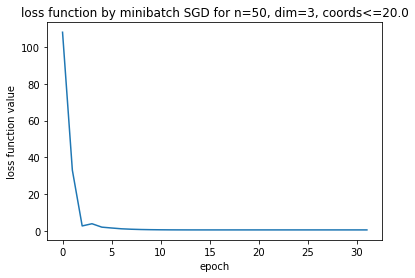

In [30]:
print_loss_function_epochs(input_3d, 50, lr=step_decay)

Тем не менее в случаях, когда ГС (СГС) сходится, значения линейной регрессии действительно уменьшаются со временем, а значит, проблема расхождения за 5000 эпох действительно возникает из-за колеблющегося графика минимизирующей функции и констанного learning rate.

Похоже на ситуацию с функций Розенброка из первой лабораторной. Там мы решили эту проблему путем пересчета lr через ступенчатую функцию, и, как видно на графиках ниже, здесь она так же помогла. Следовательно расходимость minibatch SGD без модификаций для большинства расмотренных функций - оправдана

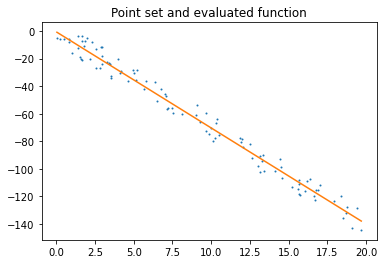

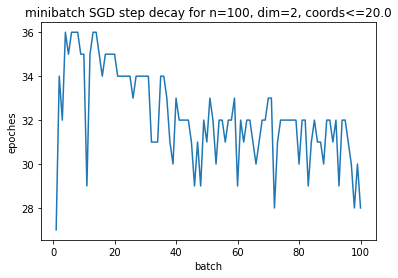

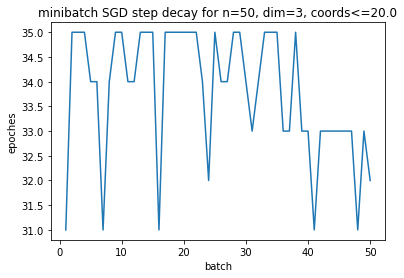

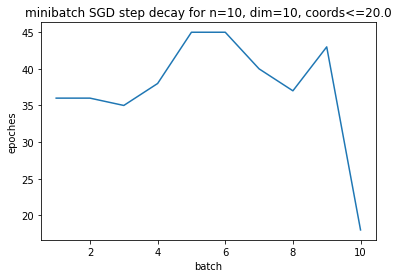

In [31]:
print_2d_result(input_2d, step_decay, sgd)
print_batch_size_analyze(input_2d, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_3d, step_decay, name = "minibatch SGD step decay")
# print_batch_size_analyze(input_small, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_large, step_decay, name = "minibatch SGD step decay")

# Пункт 2. Исследовать влияние предварительной нормализации данных на сходимость

Рассмотрим scaling к диапазону [0, 1]

In [32]:
# check if all coords are scaled
def debug_check_scaling(points, l, r):
    ok = 1
    for i in range(0, points.n):    
        for k in range(0, points.dim - 1):
            ok = ok & (l <= points.x[i][k] <= r)
        ok = ok & (l <= points.y[i] <= r)
    return ok

# call sgd with each possible batch_size for point_set & scaled_point_set
# lr - function (current_lr, epoch)
def scaling_batch_size_compare(points, lr = constant_lr, name = "minibatch SGD"):
    epoches_points = batch_size_analyze(points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='original point set', color='red')
    
    scaled_points = points
    scaled_points = apply_scaling(scaled_points)
    print("check scaling: " + str(debug_check_scaling(scaled_points, 0, 1)))
    epoches_points = batch_size_analyze(scaled_points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='scaled [0; 1] point set', color='blue')
    
    
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.legend()
    plt.show()

In [33]:
# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

### Набор точек до скалинга и после

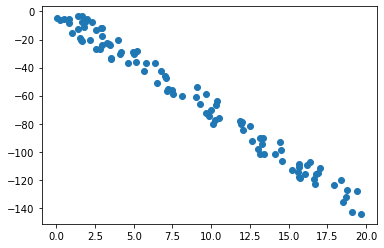

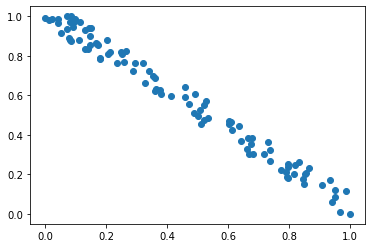

In [34]:
points = input_2d
points_scaling = apply_scaling(points)

ax = plt.figure().add_subplot()
ax.plot(points.x, points.y, 'o')

ax = plt.figure().add_subplot()
ax.plot(points_scaling.x, points_scaling.y, 'o')



Микровывод: поскольку набор точек для скаллинга всегда случайный, то нельзя сделать вывод, что скаллинг всегда выигрывает по скорости сходимости у стандартного minibatch SGD. Можно заметить, что чем плотнее изначально расположены точки, тем хуже в вопросе сходимости работает minibatch SGD со скаллингом. Так же ради интереса проверим со ступенчатой функцией: (там вообще летает)

### Сходимость со скалингом

check scaling: 1


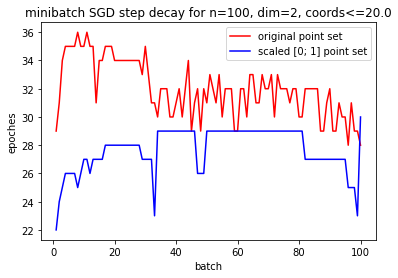

check scaling: 1


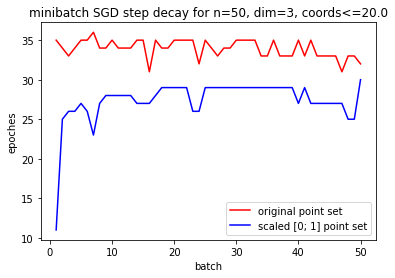

check scaling: 1


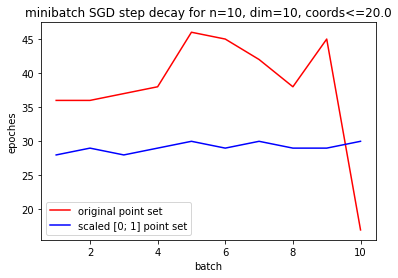

In [35]:
scaling_batch_size_compare(input_2d, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_3d, step_decay, name = "minibatch SGD step decay")
# scaling_batch_size_compare(input_small, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_large, step_decay, name = "minibatch SGD step decay")

# Пункт 3. Исследовать модификации градиентного спуска

### SGD with momentum

In [36]:
# stochastic gradient descent with momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    # grad = np.asarray([0] * points.dim)
    grad = gradinet_supplier(points, order[0 : batch_size], coeffs)
    batch_index = batch_size % points.n
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

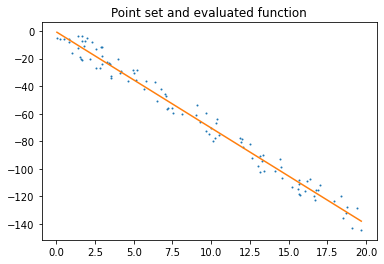

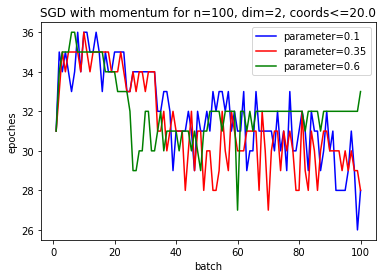

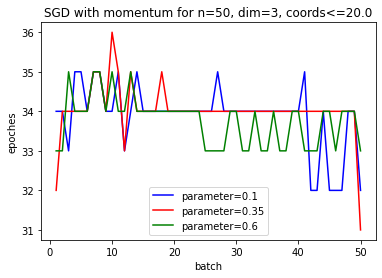

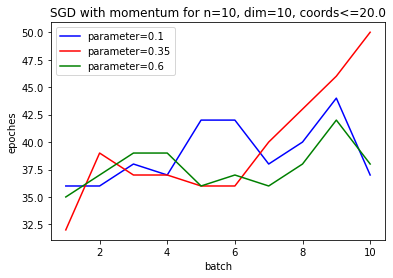

In [37]:
print_2d_result(input_2d, step_decay)
print_batch_size_analyze(input_2d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35, 0.6])
print_batch_size_analyze(input_3d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35, 0.6])
# print_batch_size_analyze(input_small, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35, 0.6])
print_batch_size_analyze(input_large, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35, 0.6])


Микровывод: SGD with momentum помогает улучшить сходимость для некоторых фукнкций, однако требователен к подбору параметра и плодит много рантайм ворнингов из-за переполнения :(

### SGD with Nesterov momentum

In [38]:
# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
#   betta - parameter
#   grad - previous step gradined
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result
    # a = np.asarray(coeffs[0 : points.dim - 1], dtype=np.float64)
    # b = np.asarray(coeffs[points.dim - 1], dtype=np.float64)
    # grad_a = np.asarray([0.] * len(a))
    # grad_b = 0.
    # prev_grad_a = grad[0 : points.dim - 1]
    # prev_grad_b = grad[points.dim - 1]
    # for i in ids:
    #     x = np.asarray(points.x[i] - betta * prev_grad_a + 1e-6, dtype=np.float64)
    #     y = np.asarray(points.y[i] - betta * prev_grad_b + 1e-6, dtype=np.float64)
    #     grad_a += 2 * (a @ x + b - y) * x
    #     grad_b += 2 * (a @ x + b - y)
    # return np.append(grad_a, grad_b)

# stochastic gradient descent with Nesterov momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   _gradinet_supplier - ignored
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    current_lr = DEFAULT_LR
    coeffs = starting_coeffs
    # grad = np.asarray([0] * points.dim)
    grad = _gradinet_supplier(points, order[0 : batch_size], coeffs)
    batch_index = batch_size % points.n

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad * 1e-6
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

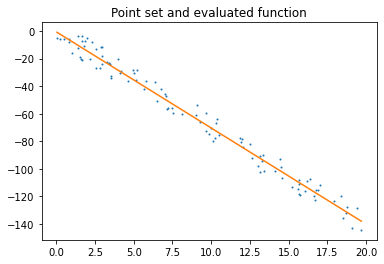

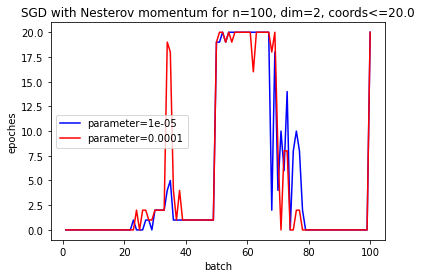

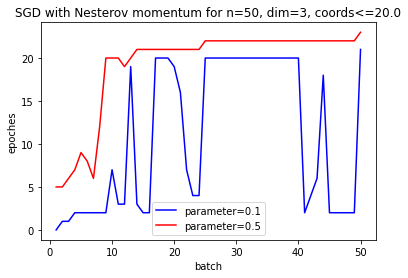

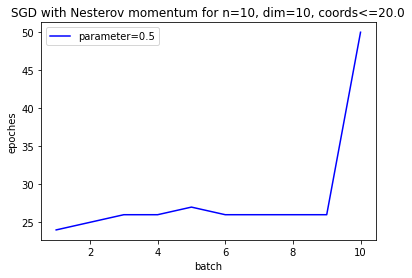

In [39]:
print_2d_result(input_2d, step_decay)
print_batch_size_analyze(input_2d, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])
print_batch_size_analyze(input_3d, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.1, 0.5])
# print_batch_size_analyze(input_small, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.1, 0.5, 0.8])
print_batch_size_analyze(input_large, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.5])
# print_batch_size_analyze(input_wild, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])
# print_batch_size_analyze(input_custom, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])

Микровывод: получили несколько изменный SGD with momentum, линии стали плавнее, что не очень понятно, хорошо или плохо. Функции, которые не сходили раньше, не сходятся и сейчас :( Запускал со ступенчатой функций и эти ГС, сходимость хотя бы при паре коэффициентов была у всех функций. Следовательно езе раз убеждаемся, что SGD, SGD with momentum и SGD with Nesterov momentum похоже друг на друга в плане производительности, и для сходимости требуется что-то более чуткое к лернинг рэйту и измерению

### ADA GRAD

In [40]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

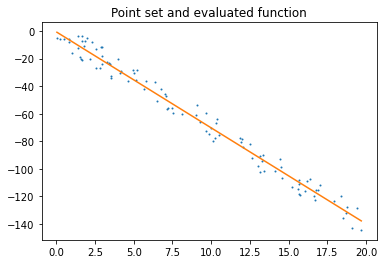

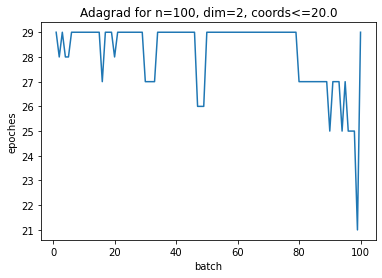

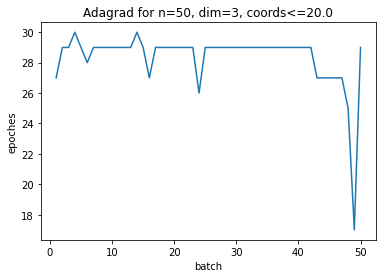

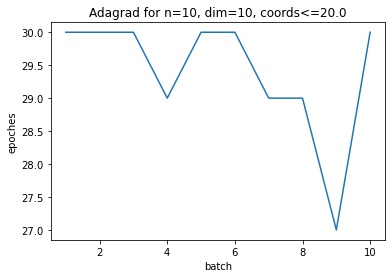

In [41]:
print_2d_result(input_2d, step_decay)
print_batch_size_analyze(input_2d, lr = step_decay, gd=adagrad, name='Adagrad')
print_batch_size_analyze(input_3d, lr = step_decay, gd=adagrad, name='Adagrad')
# print_batch_size_analyze(input_small, lr = step_decay, gd=adagrad, name='Adagrad')
print_batch_size_analyze(input_large, lr = step_decay, gd=adagrad, name='Adagrad')

### RMS Prop

In [42]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v*betta + (1-betta)*np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

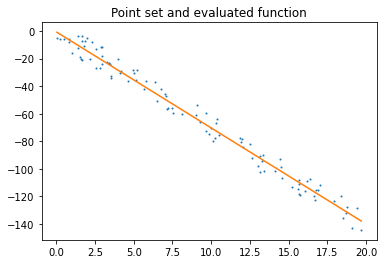

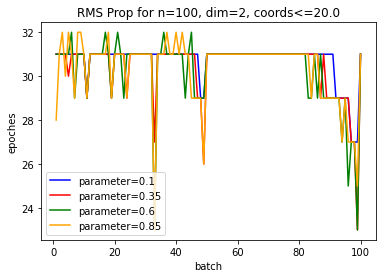

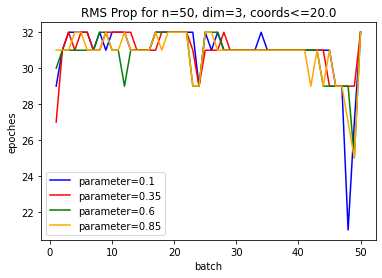

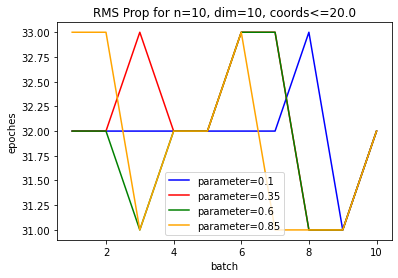

In [43]:
print_2d_result(input_2d, step_decay)
print_batch_size_analyze(input_2d, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_3d, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
# print_batch_size_analyze(input_small, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_large, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])

### ADAM

In [44]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.1] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]


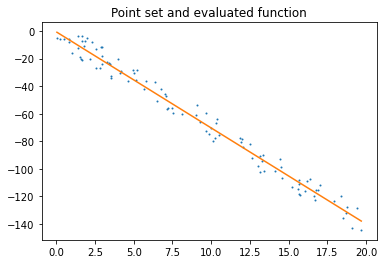

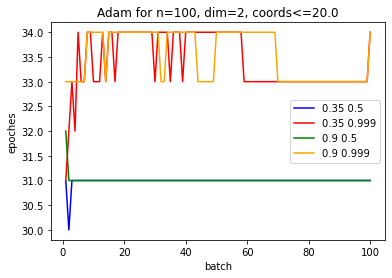

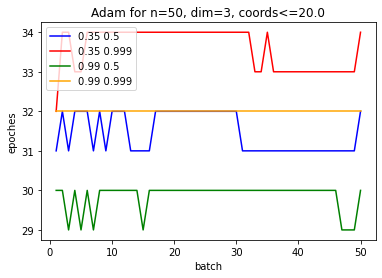

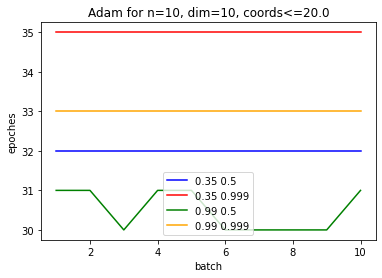

In [45]:
print_2d_result(input_2d, step_decay)
print_batch_size_analyze(input_2d, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.9], params_2=[0.5, 0.999])
print_batch_size_analyze(input_3d, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])
# print_batch_size_analyze(input_small, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])
print_batch_size_analyze(input_large, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])

# Пункт 4. Сравнить методы

In [46]:
name_function = [adam, rms_prop, adagrad, sgd_with_momentum, sgd_with_nesterov_momentum, sgd]
a_counter= [6, 11, 8, 5, 7, 5]

def call_func(points, batch, lr = step_decay, gd = sgd, param_1 = 0.01, param_2 = 0.1):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
    return len(result[1])
    

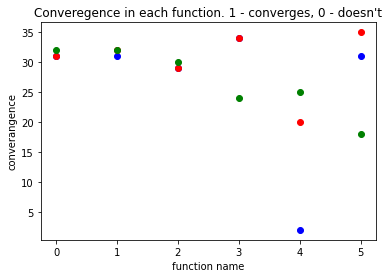

In [48]:
def draw_points_(batch, color, points):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        plt.scatter(i, res,  marker="o", color=color)



def print_convergence(draw_points, x_label, y_label, title, batch = 2):
    draw_points(batch, colors[0], input_2d)   
    draw_points(batch, colors[1], input_3d)    
    draw_points(batch, colors[2], input_large)  
    # draw_points(batch, colors[3], input_small)    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()  

print_convergence(draw_points_, "function name", "converangence", "Converegence in each function. 1 - converges, 0 - doesn't", 30)      

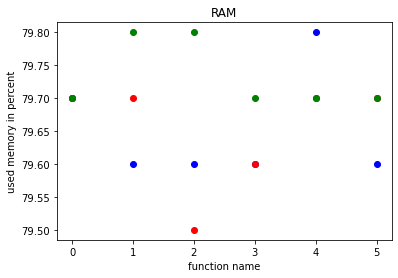

In [49]:
import psutil

def print_points_vir_memory(batch, color, points):
    for i in range(0, len(name_function)):
        batch_size_analyze(points, step_decay, gd = name_function[i])
        res = psutil.virtual_memory()[2]
        plt.scatter(i,res, marker="o", color=color)


print_convergence(print_points_vir_memory, "function name", "used memory in percent", "RAM")


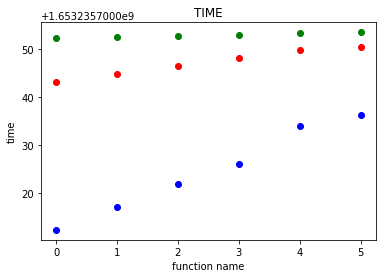

In [50]:
import time

def print_points_time(batch, color, points):
    for i in range(0, len(name_function)):
        startTime = time.time() 
        batch_size_analyze(points, step_decay, gd = name_function[i])
        lastTime = startTime
        plt.scatter(i, lastTime, marker="o", color=color)

print_convergence(print_points_time, "function name", "time", "TIME")

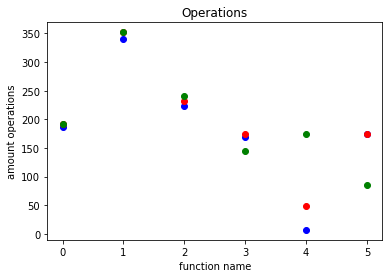

In [51]:
def print_points_operations(batch, color, points):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        plt.scatter(i, res*a_counter[i], marker="o", color=color)


print_convergence(print_points_operations, "function name","amount operations", "Operations", 20)

# Пункт 5. Построить траекторию спуска

In [52]:
def line_of_levels(points, batch = 2, lr = constant_lr, gd = sgd, param_1 = 0.1, param_2 = 0.1):
    fig, ax = plt.subplots()

    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)[1]

    min_point = result[-1]

    repoints = np.asarray(result).reshape(-1, 2)

    offset = np.max(min_point) * 30

    x = np.linspace(min_point[0] - offset, min_point[0] + offset, 300)
    y = np.linspace(min_point[1] - offset, min_point[0] + offset, 300)
    xgrid, ygrid = np.meshgrid(x,y)

    test = xgrid.copy()

    for i in range(x.size):
      for j in range(y.size):
        test[i][j] = apply_all_loss_functions(points, [xgrid[i][j], ygrid[i][j]])


    ax.plot(repoints[:, 0], repoints[:, 1], 'o-')
    ax.contour(xgrid, ygrid, test, levels=sorted([apply_all_loss_functions(points, p) for p in repoints]))
    plt.show()

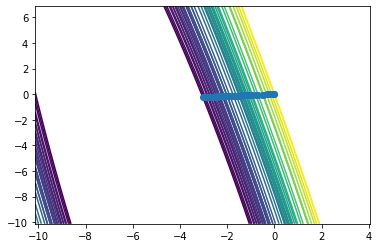

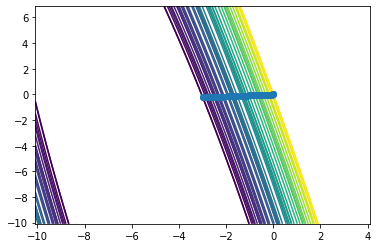

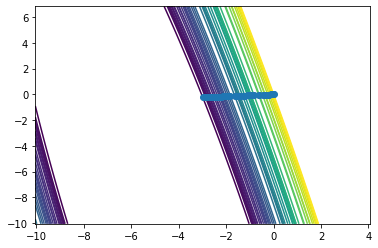

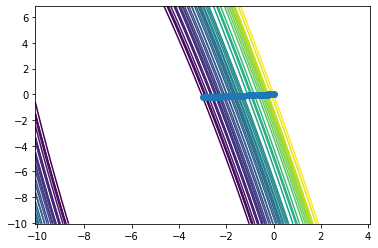

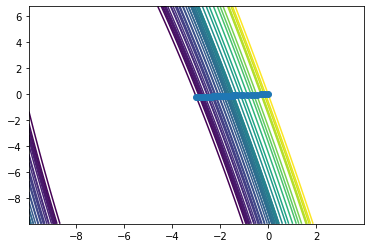

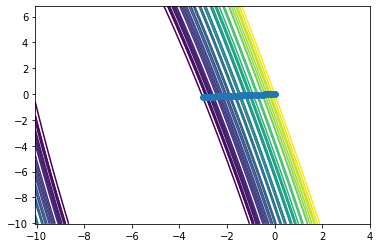

In [53]:
def print_line_of_levels(points):
    for i in range(0, len(name_function)):
        line_of_levels(points)

print_line_of_levels(input_2d)